# Table of Contents
- Initializations
- EDA - Feature Engineering
    - Check for missing values
    - Check for duplicate values
    - Text Preprocessing for Review and Summary Fields
    - Tokenization and Token Count Calculation
    - Remove Long Reviews
    - Visualizing Rating Distribution
    - Visualizing Token Count Distribution
    - Common Word Analysis Based on Rating
    - Parsing and Calculating Helpfulness Ratio
    - Visualizing Binned Distributions of Helpfulness Metrics
    - Correlation Between 'Helpfulness Ratio' and 'Rating'
    - Boxplot of Ratings by Helpfulness Ratio Bins
    - Combining 'summary' and 'reviewText' Columns
- Model Development
    - Calculating Laplace-Smoothing for Helpfulness Ratio
    - Custom Dataset Class for BERT Model
    - Load Pretrained BERT Model and Tokenizer
    - Freezing and Unfreezing Model Parameters
    - Creating DataLoaders
    - Defining the BERT Regressor Model
    - Model Setup and Training Configuration
    - Training and Evaluation Loop
- Model Evaluation
    - Plotting Training Results
    - Save Model
    - Inference and Evaluation Function
    - Model Prediction

# Initializations

In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

import transformers
from transformers import (
    BertTokenizer,
    AutoTokenizer,
    AutoModel,
    ModernBertModel
)
from transformers import get_linear_schedule_with_warmup

from tqdm import tqdm

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import json
import ast
from collections import Counter
import string
import re

In [5]:
df = pd.read_csv("/content/drive/MyDrive/BERT_rating_prediction/book_rating_40k.csv")
df

,helpful,rating,reviewText,reviewTime,summary
0,0/5,2.0,"I had really expected more from this book, it ...",NaN,Of Mice and Men- does this title suggest more?
1,"[0, 0]",5.0,I enjoyed this book very much. From the start ...,"05 26, 2014",This book is a must read!
2,0/0,1.0,How did this book get an Oprah recommendation?...,NaN,Waste of time!
3,2/2,5.0,This book is a work of art. I am using this bo...,NaN,Lord of the rings
4,3/3,4.0,"These wonderful short stories are twisted, enj...",NaN,Magically twisted short stories sure to please...
...,...,...,...,...,...
74995,3/7,3.0,"I was very excited to start this book, because...",NaN,Started off strong
74996,"[2, 2]",5.0,I have read four of the six books and I have n...,"02 6, 2014",Wonder Westmorland Reading
74997,0/0,4.0,"The interesting thesis of the book, if I under...",NaN,Why The Collective Wisdom of Crowds is Right (...
74998,"[0, 0]",4.0,I loved this book. The history behind the way ...,"02 1, 2011",I loved this


# EDA - Feature Engineering

### Check for missing values

In [8]:
df.isnull().sum()

,0
helpful,0
rating,0
reviewText,0
reviewTime,65400
summary,8


### Check for duplicate values

In [9]:
df.duplicated().sum()

np.int64(2380)

In [10]:
df.drop("reviewTime", axis=1, inplace=True)
df.dropna(inplace=True)

df.drop_duplicates(inplace=True)

### Text Preprocessing for Review and Summary Fields

In [11]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    text = text.strip()
    text = re.sub(r'https?://www.', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'(\d)\s+(\d)', r'\1\2', text)
    email_regex = re.compile(r'\b[\w\.-]+@[\w\.-]+\.\w+\b')
    text = email_regex.sub('', text)
    text = text.replace('ï»¿', '')
    return text

df['reviewText'] = df['reviewText'].apply(text_preprocessing)
df['summary'] = df['summary'].apply(text_preprocessing)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
print(df.isnull().sum())
df.dropna(inplace=True)

helpful       0
rating        0
reviewText    0
summary       0
dtype: int64


### Tokenization and Token Count Calculation

In [13]:
from transformers import BertTokenizer

tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")

# Tokenize and store token lists
df['tokens'] = df['reviewText'].apply(lambda x: tokenizer.tokenize(str(x)))

# Compute token count for each review
df['review_token_count'] = df['tokens'].apply(len)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [14]:
df['review_token_count'].describe()

,review_token_count
count,72612.000000
mean,184.306010
std,207.595866
min,0.000000
25%,61.000000
50%,119.000000
75%,229.250000
max,7229.000000


### Remove Long Reviews

In [15]:
# Count samples with more than 2048 tokens
num_long_reviews = (df['review_token_count'] > 2048).sum()
print(f"Number of reviews with more than 2048 tokens: {num_long_reviews}")

# Drop those samples
df = df[df['review_token_count'] <= 2048].reset_index(drop=True)

Number of reviews with more than 2048 tokens: 40


### Visualizing Rating Distribution

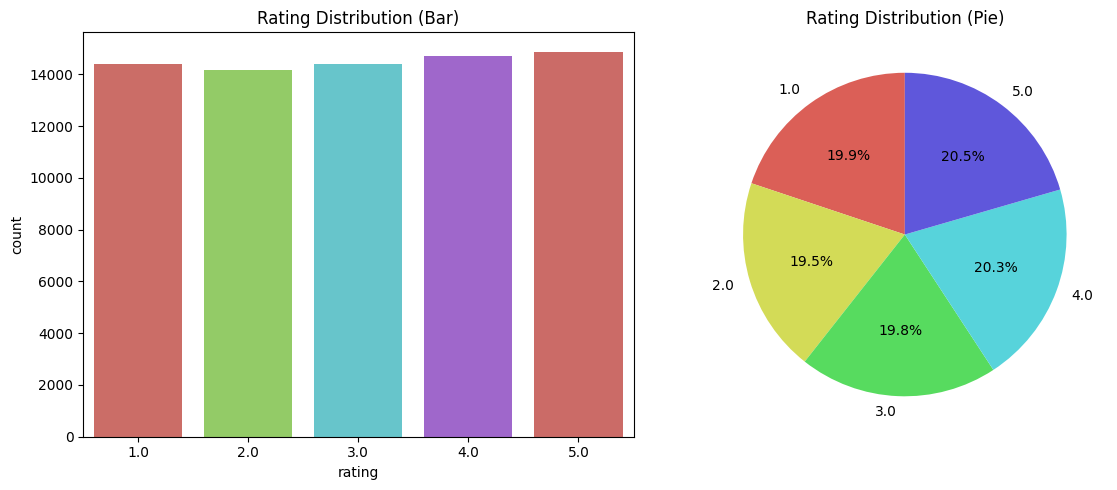

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Countplot
sns.countplot(x='rating', hue='rating', data=df, ax=axes[0], palette='hls', legend=False)
axes[0].set_title("Rating Distribution (Bar)")

# Pie chart
rating_counts = df['rating'].value_counts().sort_index()
axes[1].pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('hls'))
axes[1].set_title("Rating Distribution (Pie)")

plt.tight_layout()
plt.show()

### Visualizing Token Count Distribution

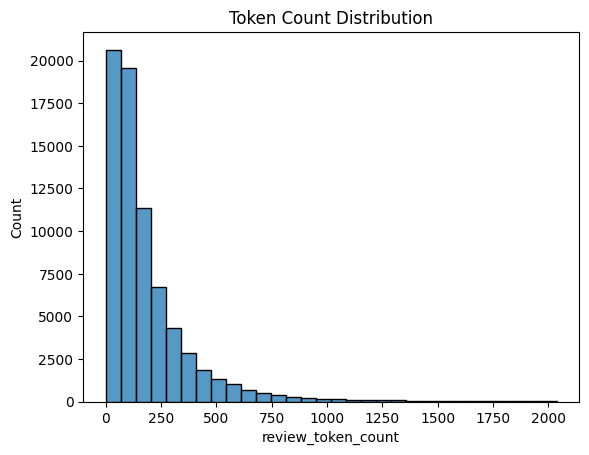

In [17]:
sns.histplot(df['review_token_count'], bins=30)
plt.title("Token Count Distribution")
df.drop("review_token_count", axis=1, inplace=True)

### Common Word Analysis Based on Rating

In [18]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Define rating thresholds
high_threshold = 4
low_threshold = 2

# Filter reviews based on rating
high_reviews = df[df['rating'] >= high_threshold]['tokens']
low_reviews = df[df['rating'] <= low_threshold]['tokens']

def clean_token(token):
    # Remove leading non-alphanumeric characters (e.g., Ġ, ▁)
    return re.sub(r'^[^a-zA-Z0-9]+', '', token)

# Filter function for token lists
def filter_tokens(tokens):
    cleaned = []
    for token in tokens:
        clean = clean_token(token).lower()
        if clean and clean not in stop_words and clean not in punctuation and len(clean) > 1:
            cleaned.append(clean)
    return cleaned

# Flatten and filter token lists
high_tokens = [token for tokens in high_reviews for token in filter_tokens(tokens)]
low_tokens = [token for tokens in low_reviews for token in filter_tokens(tokens)]

# Count most common words
high_common = Counter(high_tokens).most_common(10)
low_common = Counter(low_tokens).most_common(10)

high_df = pd.DataFrame(high_common, columns=['Word', 'Frequency'])
low_df = pd.DataFrame(low_common, columns=['Word', 'Frequency'])

# Display results
print("\nMost common words in HIGH rating reviews:")
print(high_df)

print("\nMost common words in LOW rating reviews:")
print(low_df)

# Drop 'tokens' column, it's no longer needed
df.drop('tokens', axis=1, inplace=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Most common words in HIGH rating reviews:
    Word  Frequency
0   book      51113
1   read      23676
2    one      18735
3  story      14791
4   like      11460
5   quot      10569
6   good      10116
7  would       9564
8   well       9073
9   time       9028

Most common words in LOW rating reviews:
    Word  Frequency
0   book      58857
1   read      18870
2    one      18122
3   like      14676
4   quot      14586
5  would      13379
6  story      11758
7   good       9076
8  books       9014
9   time       8897


### Parsing and Calculating Helpfulness Ratio

In [19]:
def parse_helpful(value):
    try:
        # If the value is a string that represents a list, [1,2]
        if isinstance(value, str) and value.startswith("[") and value.endswith("]"):
            parsed = ast.literal_eval(value)
            if isinstance(parsed, list) and len(parsed) == 2:
                return parsed[0], parsed[1]
         # If the value is a string representing a fraction, 1/2
        elif isinstance(value, str) and '/' in value:
            helpful_votes, total_votes = map(int, value.split('/'))
            return helpful_votes, total_votes
    except:
        pass
    return 0, 0

df[['helpful_votes', 'total_votes']] = df['helpful'].apply(
    lambda x: pd.Series(parse_helpful(x))
)

# Calculate the helpfulness ratio (helpful_votes / total_votes) for each row.
# If total_votes is 0, set the ratio to 0 to avoid division by zero.
df['helpfulness_ratio'] = np.where(
    df['total_votes'] == 0,
    0,
    np.round(df['helpful_votes'] / df['total_votes'], 2)
)

df.drop('helpful', axis=1, inplace=True)

### Visualizing Binned Distributions of Helpfulness Metrics

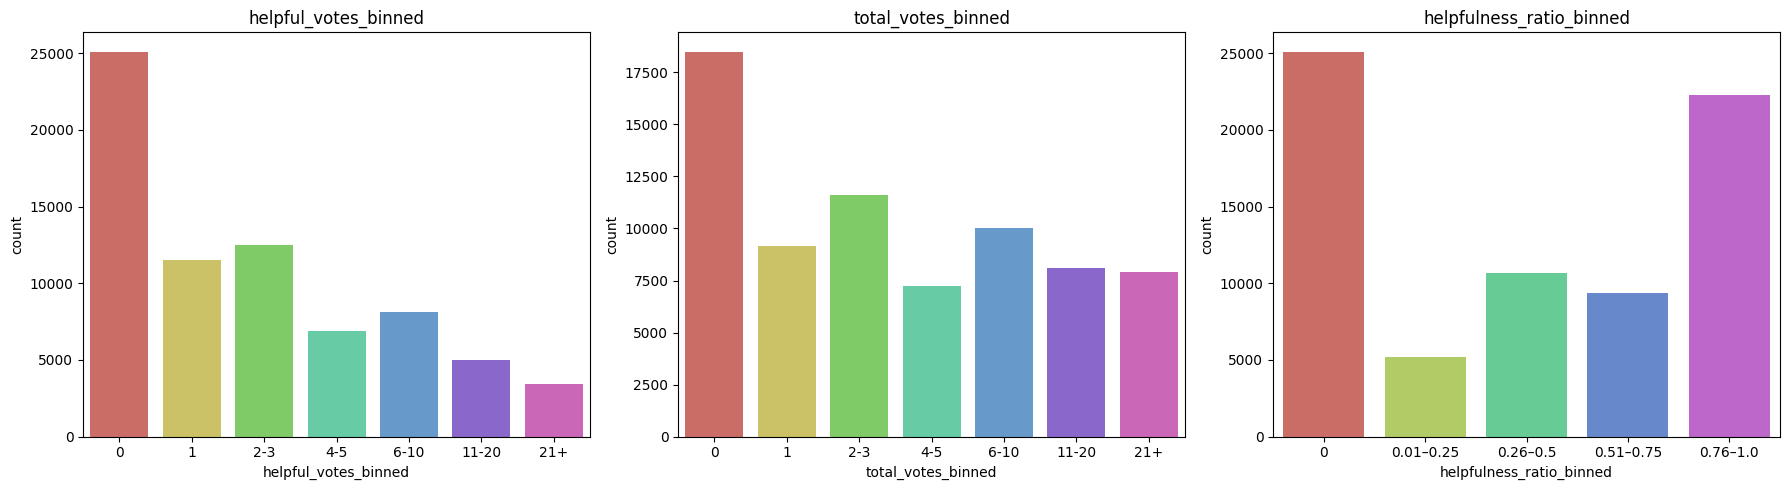

In [20]:
df['helpful_votes_binned'] = pd.cut(df['helpful_votes'], bins=[-1, 0, 1, 3, 5, 10, 20, np.inf],
                                     labels=['0', '1', '2-3', '4-5', '6-10', '11-20', '21+'])

df['total_votes_binned'] = pd.cut(df['total_votes'], bins=[-1, 0, 1, 3, 5, 10, 20, np.inf],
                                   labels=['0', '1', '2-3', '4-5', '6-10', '11-20', '21+'])

df['helpfulness_ratio_binned'] = pd.cut(df['helpfulness_ratio'], bins=[-0.01, 0, 0.25, 0.5, 0.75, 1.0],
                                        labels=['0', '0.01–0.25', '0.26–0.5', '0.51–0.75', '0.76–1.0'])


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(x='helpful_votes_binned', hue="helpful_votes_binned", data=df, ax=axes[0], palette='hls')
axes[0].set_title("helpful_votes_binned")

sns.countplot(x='total_votes_binned', hue="total_votes_binned",data=df, ax=axes[1], palette='hls')
axes[1].set_title("total_votes_binned")

sns.countplot(x='helpfulness_ratio_binned', hue="helpfulness_ratio_binned", data=df, ax=axes[2], palette='hls')
axes[2].set_title("helpfulness_ratio_binned")

plt.tight_layout()
plt.show()

df.drop('helpful_votes_binned', axis=1, inplace=True)
df.drop('total_votes_binned', axis=1, inplace=True)
df.drop('helpfulness_ratio_binned', axis=1, inplace=True)

### Correlation Between 'Helpfulness Ratio' and 'Rating'

In [21]:
correlation = df['rating'].corr(df['helpfulness_ratio'])
print(f"Correlation between 'helpfulness_ratio' and 'rating': {correlation}")

# Almost no correlation between 'helpfulness_ratio' and 'rating'

# Helpfullnes may have affected the rating positively or negatively,
# So it makes sense that the correlation is close to 0.

Correlation between 'helpfulness_ratio' and 'rating': 0.0503661870204271


### Boxplot of Ratings by Helpfulness Ratio Bins

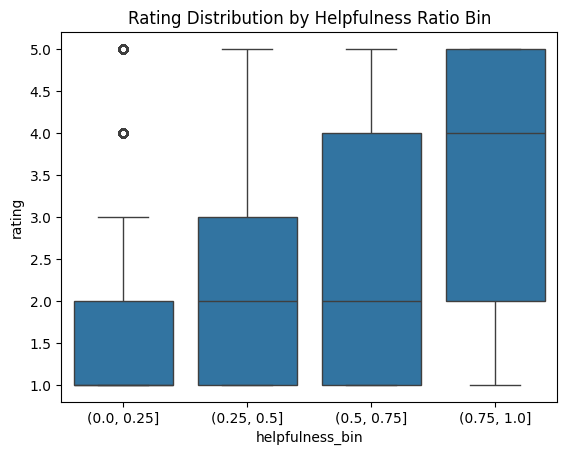

In [22]:
df['helpfulness_bin'] = pd.cut(df['helpfulness_ratio'], bins=[0, 0.25, 0.5, 0.75, 1.0])
sns.boxplot(x='helpfulness_bin', y='rating', data=df)
plt.title("Rating Distribution by Helpfulness Ratio Bin")
plt.show()
df.drop("helpfulness_bin", axis=1, inplace=True)

In [23]:
df.dtypes

,0
rating,float64
reviewText,object
summary,object
helpful_votes,int64
total_votes,int64
helpfulness_ratio,float64


### Combining 'summary' and 'reviewText' Columns

In [24]:
df['reviewText'] = df["reviewText"].replace("\n", " ")
df["combined_text"] = df["summary"] + " " + df["reviewText"]

df.drop("reviewText", axis=1, inplace=True)
df.drop("summary", axis=1, inplace=True)

In [26]:
df.head()

,rating,helpful_votes,total_votes,helpfulness_ratio,combined_text
0,2.0,0,5,0.0,Of Mice and Men does this title suggest more ...
1,5.0,0,0,0.0,This book is a must read I enjoyed this book ...
2,1.0,0,0,0.0,Waste of time How did this book get an Oprah ...
3,5.0,2,2,1.0,Lord of the rings This book is a work of art ...
4,4.0,3,3,1.0,Magically twisted short stories sure to please...


# Model Development

### Calculating Laplace-Smoothing for Helpfulness Ratio

In [27]:
α = 5
μ = (
    df["helpful_votes"].sum()
    / df["total_votes"].replace(0, np.nan).sum()
)

# Laplace smoothing
df["smoothed_ratio"] = (
    df["helpful_votes"] + α * μ
) / (df["total_votes"] + α)

# Normalize to mean=1
df["weight"] = df["smoothed_ratio"] / df["smoothed_ratio"].mean()

df.drop("helpful_votes", axis=1, inplace=True)
df.drop("total_votes", axis=1, inplace=True)
df.drop('helpfulness_ratio', axis=1, inplace=True)

### Custom Dataset Class for BERT Model

In [28]:
class BERTDataset(Dataset):
    """
    A custom dataset class for tokenizing and processing text data for BERT-based models.

    Attributes:
        data (pandas.DataFrame): DataFrame containing the dataset.
        tokenizer (transformers.PreTrainedTokenizer): The tokenizer used to tokenize the input text.
        max_len (int): Maximum length for tokenized text sequences.
    """
  def __init__(self, data, tokenizer, max_len):
    """
        Initializes the BERTDataset object.

        Parameters:
            data (pandas.DataFrame): The input DataFrame containing the dataset. It should have at least
                                      a 'combined_text' column (text data) and 'rating' column (target values).
            tokenizer (transformers.PreTrainedTokenizer): The tokenizer used to tokenize the input text.
            max_len (int): The maximum length of the tokenized sequence. Sequences longer than this will
                           be truncated, and shorter ones will be padded.
    """
    self.data = data
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    """
        Returns the number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
    return len(self.data)

  def __getitem__(self, index):
    """
        Fetches a single data sample (text and label) and processes it for the model.

        Parameters:
            index (int): The index of the sample to retrieve from the dataset.

        Returns:
            dict: A dictionary containing the following:
                - 'input_ids' (torch.Tensor): The tokenized input sequence of shape (max_len,).
                - 'attention_mask' (torch.Tensor): The attention mask to indicate the padded tokens.
                - 'weight' (torch.Tensor): The weight corresponding to the sample, used for weighted loss calculation.
                - 'label' (torch.Tensor): The target label (rating) for the text, as a float32 tensor.
        """
    row = self.data.iloc[index]

    # Tokenize texts
    encoding = self.tokenizer(
           row["combined_text"],
           padding='max_length',
           truncation=True,
           max_length=self.max_len,
           return_tensors="pt"
       )

    # Prepare targets
    label = torch.tensor(row["rating"], dtype=torch.float32)

    return {
        'input_ids': encoding['input_ids'].squeeze(0),
        'attention_mask': encoding['attention_mask'].squeeze(0),
        "weight": torch.tensor(row["weight"], dtype=torch.float32),
        'label': label
    }

### Load Pretrained BERT Model and Tokenizer

In [29]:
model_name = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

### Freezing and Unfreezing Model Parameters

In [30]:
for param in model.parameters():
    param.requires_grad = False

K = 8
for layer in model.layers[-K:]:
    for param in layer.parameters():
        param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

### Creating DataLoaders

In [32]:
max_len = 2048
batch_size = 16

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = BERTDataset(train_df, tokenizer, max_len)
test_dataset = BERTDataset(test_df, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Defining the BERT Regressor Model

In [33]:
class BERTRegressor(nn.Module):
  """
    A custom PyTorch model for regression tasks using a pre-trained BERT model followed by a regression head.

    Attributes:
        bert (transformers.PreTrainedModel): The pre-trained BERT model
        regressor (nn.Sequential): A sequence of layers for the regression task, which includes a dropout,
                                   a linear layer, a GELU activation, and another linear layer for output.
    """
    def __init__(self, base_model):
        super().__init__()
        """
        Initializes the BERTRegressor model.

        Parameters:
            base_model (transformers.PreTrainedModel): A pre-trained BERT model

        """

        self.bert = base_model

        self.regressor = nn.Sequential(
             nn.Dropout(0.3),
             nn.Linear(self.bert.config.hidden_size, 128),
             nn.ReLU(),
             nn.Linear(128, 1), # Regression output
         )

    def forward(self, input_ids, attention_mask):
      """
        Defines the forward pass of the model.

        Parameters:
            input_ids (torch.Tensor): The tokenized input sequence of shape `(batch_size, sequence_length)`.
            attention_mask (torch.Tensor): The attention mask for the input sequence, which indicates the padded tokens
                                          with a value of 0 and the real tokens with a value of 1.

        Returns:
            torch.Tensor: The model's predicted regression value for each input sample, shaped `(batch_size,)`.
        """
        cls = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]

        return self.regressor(cls).squeeze(-1)

### Model Setup and Training Configuration

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"

num_epochs = 3
freq =  200

model = BERTRegressor(model)
model = model.to(device)

loss_fn = nn.MSELoss(reduction='none')
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

torch.set_float32_matmul_precision('high')

### Training and Evaluation Loop

In [ ]:
# Train a single epoch
def train_epoch(model, optimizer, scheduler, loss_fn, input_ids, attn_mask, label, device, weight):
  """
    Performs one step of training for a single epoch.

    Parameters:
        model (nn.Module): The BERT model to be trained.
        optimizer (torch.optim.Optimizer): The optimizer used for updating model parameters.
        scheduler (torch.optim.lr_scheduler): The learning rate scheduler to adjust the learning rate.
        loss_fn (function): The loss function used to compute the loss between predictions and true values.
        input_ids (torch.Tensor): The input token IDs to the model (batch size x sequence length).
        attn_mask (torch.Tensor): The attention mask for the input sequences, marking the real tokens and padding.
        label (torch.Tensor): The true labels (target values) for the regression task.
        device (torch.device): The device (CPU or GPU) where the model and tensors should be loaded.
        weight (torch.Tensor): The weight to be applied to the loss for each sample.

    Returns:
        weighted_loss (float): The mean weighted loss for this batch.
        output (torch.Tensor): The model's output predictions for the input batch.
        lr (float): The current learning rate after the optimizer step.
    """

    optimizer.zero_grad()

    output = model(input_ids=input_ids, attention_mask=attn_mask)

    losses = loss_fn(output, label)
    weighted_loss = (losses * weight).mean()
    weighted_loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

    lr = optimizer.param_groups[0]["lr"]

    return weighted_loss.item(), output, lr

# Evaluate the model
def evaluate(model, test_loader, loss_fn, device):
  """
    Evaluates the model on the test dataset.

    Parameters:
        model (nn.Module): The trained model.
        test_loader (DataLoader): DataLoader for the test dataset.
        loss_fn (function): The loss function to compute the loss.
        device (torch.device): The device (CPU or GPU) where the model and tensors should be loaded.

    Returns:
        avg_val_loss (float): The average validation loss across the entire test set.
        mae (float): The Mean Absolute Error (MAE) for the predictions.
        mse (float): The Mean Squared Error (MSE) for the predictions.
        r2 (float): The R-squared score for the predictions.
        true_vals (numpy.ndarray): The true target values for the test set.
        preds (numpy.ndarray): The predicted target values by the model.
    """
    model.eval()
    total_val_loss = 0.
    preds, true_vals = [], []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating", leave=False):
            input_ids = batch["input_ids"].to(device)
            attn_mask = batch["attention_mask"].to(device)
            targets = batch["label"].float().to(device)
            weights = batch["weight"].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attn_mask)

            loss = loss_fn(outputs, targets)
            weighted_loss = (loss * weights).mean()
            total_val_loss += weighted_loss.item()

            preds.extend(outputs.cpu().numpy())
            true_vals.extend(targets.cpu().numpy())

    true_vals = np.array(true_vals)
    preds = np.array(preds)

    # Compute regression metrics
    mae = mean_absolute_error(true_vals, preds)
    mse = mean_squared_error(true_vals, preds)
    r2  = r2_score(true_vals, preds)

    avg_val_loss = total_val_loss / len(test_loader)
    return avg_val_loss, mae, mse, r2, true_vals, preds

# Train function
def train(model, train_loader, test_loader, loss_fn, optimizer, scheduler, num_epochs, freq, device):
  """
    Trains the model for a specified number of epochs and evaluates it after each epoch.

    Parameters:
        model (nn.Module): The model to be trained.
        train_loader (DataLoader): The DataLoader for the training dataset.
        test_loader (DataLoader): The DataLoader for the test dataset.
        loss_fn (function): The loss function for training.
        optimizer (torch.optim.Optimizer): The optimizer to update model parameters.
        scheduler (torch.optim.lr_scheduler): The learning rate scheduler to adjust the learning rate.
        num_epochs (int): The number of epochs to train the model.
        freq (int): The frequency of printing the loss during training.
        device (torch.device): The device (CPU or GPU) for training.

    Returns:
        model (nn.Module): The trained model.
        train_losses (list): A list of training losses per epoch.
        val_losses (list): A list of validation losses per epoch.
        mae_arr (list): A list of MAE (Mean Absolute Error) values per epoch.
        mse_arr (list): A list of MSE (Mean Squared Error) values per epoch.
        r2_arr (list): A list of R-squared values per epoch.
    """
    print(f"\nTotal Batch: {len(train_loader)}\n")

    train_losses, val_losses = [], []
    mae_arr, mse_arr, r2_arr = [], [], []

    for epoch in range(num_epochs):
        print(f"\nEPOCH {epoch + 1}/{num_epochs}")
        print("###################################")

        model.train()

        total_loss = 0.
        global_step = 0
        last_loss = 0.

        for batch in tqdm(train_loader, desc="Training", leave=False):
            input_ids = batch["input_ids"].to(device)
            attn_mask = batch["attention_mask"].to(device)
            weight = batch["weight"].to(device)
            label = batch["label"].float().to(device)

            loss, _, lr = train_epoch(model, optimizer, scheduler, loss_fn, input_ids, attn_mask, label, device, weight)

            total_loss += loss
            global_step += 1

            # Print loss
            if global_step % freq == 0:
                last_loss = total_loss / freq
                print(f"  Loss: {last_loss:.2f} | Lr: {lr:.6f}")
                total_loss = 0.

        # Evaluate the model after each epoch
        avg_val_loss, mae, mse, r2, true_labels, preds = evaluate(model, test_loader, loss_fn, device)

        print(f"\nTrain Loss: {last_loss:.2f} | Valid Loss: {avg_val_loss:.2f} | Lr: {lr:.10f}")
        print(f"\nEvaluation Metrics:\n"
              f"  MAE:  {mae:.2f}\n"
              f"  MSE:  {mse:.2f}\n"
              f"  R2: {r2:.2f}\n")

        train_losses.append(last_loss)
        val_losses.append(avg_val_loss)
        mae_arr.append(mae)
        mse_arr.append(mse)
        r2_arr.append(r2)

    return model, train_losses, val_losses, mae_arr, mse_arr, r2_arr

new_model, train_loss, val_los, mae, mse, r2 = train(
    model,
    train_loader,
    test_loader,
    loss_fn,
    optimizer,
    scheduler,
    num_epochs,
    freq,
    device
)


Total Batch: 3629


EPOCH 1/3
###################################


Training:   0%|          | 1/3629 [01:04<64:33:12, 64.06s/it]

# Model Evaluation

### Plotting Training Results

In [ ]:
def plot_results(train_loss, val_loss, mae, mse, r2):
  """
  This function plots the training and evaluation results for different metrics across epochs.

  Parameters:
    train_loss: List of training loss values for each epoch
    val_loss: List of validation loss values for each epoch
    mae: List of Mean Absolute Error (MAE) values for each epoch
    mse: List of Mean Squared Error (MSE) values for each epoch
    r2: List of R-Squared (R2) values for each epoch

  Return:
    This function does not return any value. It only visualizes the results in a plot.
  """
  num_epochs = list(range(1, len(train_loss)+1))

  plt.figure()

  fig, axes = plt.subplots(2, 2, figsize=(12, 6))

  axes[0,0].plot(num_epochs, train_loss, label="Train Loss")
  axes[0,0].plot(num_epochs, val_loss, linestyle="-.", label="Validation loss")
  axes[0,0].set_xlabel("Epoch")
  axes[0,0].set_ylabel("Loss")
  axes[0,0].legend()

  axes[0,1].plot(num_epochs, mae)
  axes[0,1].set_xlabel("Epoch")
  axes[0,1].set_ylabel("MAE")

  axes[1,0].plot(num_epochs, mse)
  axes[1,0].set_xlabel("Epoch")
  axes[1,0].set_ylabel("MSE")

  axes[1,1].plot(num_epochs, r2)
  axes[1,1].set_xlabel("Epoch")
  axes[1,1].set_ylabel("R2")

  fig.tight_layout()
  plt.show()

In [ ]:
plot_results(train_loss, val_los, mae, mse, r2)

### Save Model

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/BERT_rating_prediction/model/weights.pth")
torch.save(model.state_dict(), "/content/drive/MyDrive/BERT_rating_prediction/model/weights.bin")
tokenizer.save_pretrained("/content/drive/MyDrive/BERT_rating_prediction/model/tokenizer/")

In [ ]:
test_df.drop(['smoothed_ratio'], axis=1, inplace=True)
test_df.columns

### Inference and Evaluation Function

In [ ]:
def inference(model, test_loader, device):
  """
  This function performs the inference (prediction) phase of a trained model on a test dataset.

  Parameters:
    model: The trained model to make predictions
    test_loader: A DataLoader that provides the test dataset in batches
    device: The device on which the model and data will be processed (e.g., 'cuda' or 'cpu')

  Returns:
    mse: Mean Squared Error between predictions and true labels
    mae: Mean Absolute Error between predictions and true labels
    r2: R-squared (R2) score between predictions and true labels
    all_labels: The true labels from the test dataset
    all_preds: The model's predictions for the test dataset
  """
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            weight = batch["weight"].to(device)
            labels = batch["label"].float().to(device)

            # Get predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute regression metrics
    mse = mean_squared_error(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)
    r2 = r2_score(all_labels, all_preds)

    return mse, mae, r2, all_labels, all_preds

In [ ]:
mse, mae, r2, true_labels, preds = inference(new_model, test_loader, device)

print(f"\nMAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R2 : {r2:.2f}")

test_df["preds"] = preds

# Clip predictions to max value of 5.0
test_df["preds"] = test_df["preds"].clip(upper=5.0)

# Round predictions to nearest integer (e.g., 4.74 → 5)
test_df["preds"] = test_df["preds"].round()

In [ ]:
test_df.drop(["weight"], axis=1, inplace=True)

### Model prediction

In [ ]:
test_df.head(10)